# Generating maze with rewards and agent

Defining maze environment with objects, such as obstacles, agent and reward.

In [4]:
import matplotlib.pyplot as plt
import numpy as np

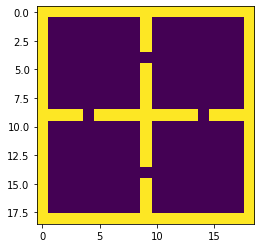

In [5]:
# Four room task
x = np.array([np.ones(19),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [0], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),                                    
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.concatenate([np.ones(4), [0],  np.ones(9), [0], np.ones(4)]),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [0], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.ones(19)])

start_idx = [[4, 4]] 
goal_idx = [[14, 14]] 
env_id = 'FourRoom-v0'

plt.imshow(x)

In [6]:
import numpy as np
from mazelab import BaseMaze
from mazelab import Object
from mazelab import DeepMindColor as color


class Maze(BaseMaze):
    @property
    def size(self):
        return x.shape
    
    def make_objects(self):
        free = Object('free', 0, color.free, False, np.stack(np.where(x == 0), axis=1))
        obstacle = Object('obstacle', 1, color.obstacle, True, np.stack(np.where(x == 1), axis=1))
        agent = Object('agent', 2, color.agent, False, [])
        goal = Object('goal', 3, color.goal, False, [])
        return free, obstacle, agent, goal

In [7]:
from mazelab import BaseEnv
from mazelab import VonNeumannMotion
import gym
from gym.spaces import Box
from gym.spaces import Discrete


class Env(BaseEnv):
    def __init__(self):
        super().__init__()
        
        self.maze = Maze()
        self.motions = VonNeumannMotion()
        
        self.observation_space = Box(low=0, high=len(self.maze.objects), shape=self.maze.size, dtype=np.uint8)
        self.action_space = Discrete(len(self.motions))
        
    def step(self, action):
        motion = self.motions[action]
        current_position = self.maze.objects.agent.positions[0]
        new_position = [current_position[0] + motion[0], current_position[1] + motion[1]]
        valid = self._is_valid(new_position)
        if valid:
            self.maze.objects.agent.positions = [new_position]
        
        if self._is_goal(new_position):
            reward = +1
            done = True
        elif not valid:
            reward = -1
            done = False
        else:
            reward = -0.01
            done = False
        return self.maze.to_value(), reward, done, {}
        
    def reset(self):
        self.maze.objects.agent.positions = start_idx
        self.maze.objects.goal.positions = goal_idx
        return self.maze.to_value()
    
    def _is_valid(self, position):
        nonnegative = position[0] >= 0 and position[1] >= 0
        within_edge = position[0] < self.maze.size[0] and position[1] < self.maze.size[1]
        passable = not self.maze.to_impassable()[position[0]][position[1]]
        return nonnegative and within_edge and passable
    
    def _is_goal(self, position):
        out = False
        for pos in self.maze.objects.goal.positions:
            if position[0] == pos[0] and position[1] == pos[1]:
                out = True
                break
        return out
    
    def get_image(self):
        return self.maze.to_rgb()

In [8]:
gym.envs.register(id='FourRoom-v0', entry_point=Env, max_episode_steps=1000)

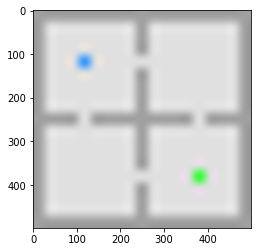

In [9]:
env = gym.make(env_id)
env.reset()
img = env.render('rgb_array')
plt.imshow(img)

# Finding the shortest way

[Dijkstra's algorithm](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm) is an algorithm for finding the shortest path between nodes in a graph, producing shortest-path tree.

In [12]:
actions = dijkstra_solver(True, VonNeumannMotion, start_idx, goal_idx)


AssertionError: 

In [9]:
from mazelab.solvers import dijkstra_solver

impassable_array = env.unwrapped.maze.to_impassable()
motions = env.unwrapped.motions
start = env.unwrapped.maze.objects.agent.positions[0]
goal = env.unwrapped.maze.objects.goal.positions[0]
actions = dijkstra_solver(impassable_array, motions, start, goal)
print(actions)
env = gym.wrappers.Monitor(env, './', force=True)
rewards = 0.0
env.reset()
for action in actions:
    _, reward, _, _ = env.step(action)
    rewards += reward
env.close()
print(rewards)

[1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3]


FileNotFoundError: [WinError 2] The system cannot find the file specified: 'c:\\Users\\48786\\Documents\\GitHub\\maze-generator\\.ipynb_checkpoints\\openaigym.video.0.1928.video000000.mp4'

In [10]:
import imageio
from IPython.display import Image
from pathlib import Path
f = list(Path('./').glob('*.mp4'))[0]
reader = imageio.get_reader(f)
f = f'./{env_id}.gif'
with imageio.get_writer(f, fps=3) as writer:
    [writer.append_data(img) for img in reader]
Image(f)

IndexError: list index out of range

# Transforming maze into a graph

Goal of the project is to achieve graph-based representation of an environment that can be tuned according to behaviour of an agent.

In [11]:
print(x)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.

In [12]:
import networkx as nx
import pylab as plt

G = nx.DiGraph()
#go node by node and check if his neighbour is available 

#nx.draw(graph) #this function takes in a optional second argument of the positions
#plt.show()


In [18]:
for idx in range(len(x.flatten())):
    if x.flatten()[idx]==0:
        G.add_node(idx)

In [14]:
G.nodes
plt.show()